Import libraries to perfrom Extract-Transform-Load (ETL) and Exploratory Data Analysis (EDA)

In [1]:
library(ggplot2)
library(tidyverse)
library(readxl)
install.packages('corrplot')
library(corrplot)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --

v tibble  3.0.5     v purrr   0.3.2
v tidyr   0.8.3     v dplyr   1.0.3
v readr   1.3.1     v stringr 1.4.0
v tibble  3.0.5     v forcats 0.4.0

Warning message:
"package 'tibble' was built under R version 3.6.3"
Warning message:
"package 'dplyr' was built under R version 3.6.3"
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



package 'corrplot' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\luis_\AppData\Local\Temp\Rtmpi4bGfK\downloaded_packages


Warning message:
"package 'corrplot' was built under R version 3.6.3"
corrplot 0.84 loaded



In [2]:
df = read.csv("https://raw.githubusercontent.com/luisrrc/Power-Plant-with-R/main/Folds5x2_pp.csv")

In [3]:
class(df)

[1] "data.frame"

See first few rows:

In [4]:
head(df)

AT,V,AP,RH,PE
8.34,40.77,1010.84,90.01,480.48
23.64,58.49,1011.40,74.20,445.75
29.74,56.90,1007.15,41.91,438.76
19.07,49.69,1007.22,76.79,453.09
11.80,40.66,1017.13,97.20,464.43
13.97,39.16,1016.05,84.60,470.96


The columns in the DataFrame are:

AT = Atmospheric Temperature in C

V = Exhaust Vacuum Speed

AP = Atmospheric Pressure

RH = Relative Humidity

PE = Power Output

Power Output is the value we are trying to predict given the measurements above.

Size of  DataFrame:

In [5]:
dim(df)

[1] 9568    5

class of each column in the DataFrame:

In [6]:
library(purrr)
install.packages('dplyr')

map(df, class)

Warning message:
"package 'dplyr' is in use and will not be installed"


$AT
[1] "numeric"

$V
[1] "numeric"

$AP
[1] "numeric"

$RH
[1] "numeric"

$PE
[1] "numeric"

Check for missing values:

In [7]:
map(df, ~sum(is.na(.)))

$AT
[1] 0

$V
[1] 0

$AP
[1] 0

$RH
[1] 0

$PE
[1] 0

#### Visualize relationship between variables

Correlation between Atmospheric Temperature and Power Output: 

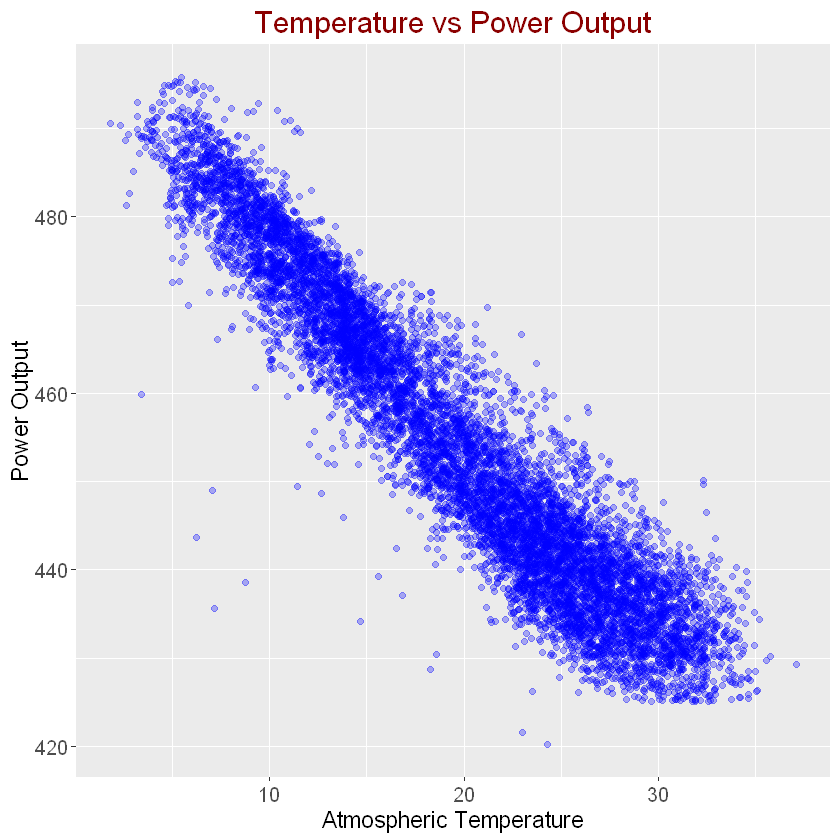

In [8]:
df %>% ggplot(aes(AT, PE)) + geom_point(color = "blue", alpha = 0.3) +
    ggtitle("Temperature vs Power Output") + xlab("Atmospheric Temperature") +
    ylab("Power Output") + theme(plot.title = element_text(color = "darkred",
                                                          size = 18, hjust = 0.5),
                                axis.text.y = element_text(size = 12),
                                axis.text.x = element_text(size = 12, hjust = 0.5),
                                axis.title.x = element_text(size = 14),
                                axis.title.y = element_text(size = 14))

Correlation between Exhaust Vacuum Speed and Power Output: 

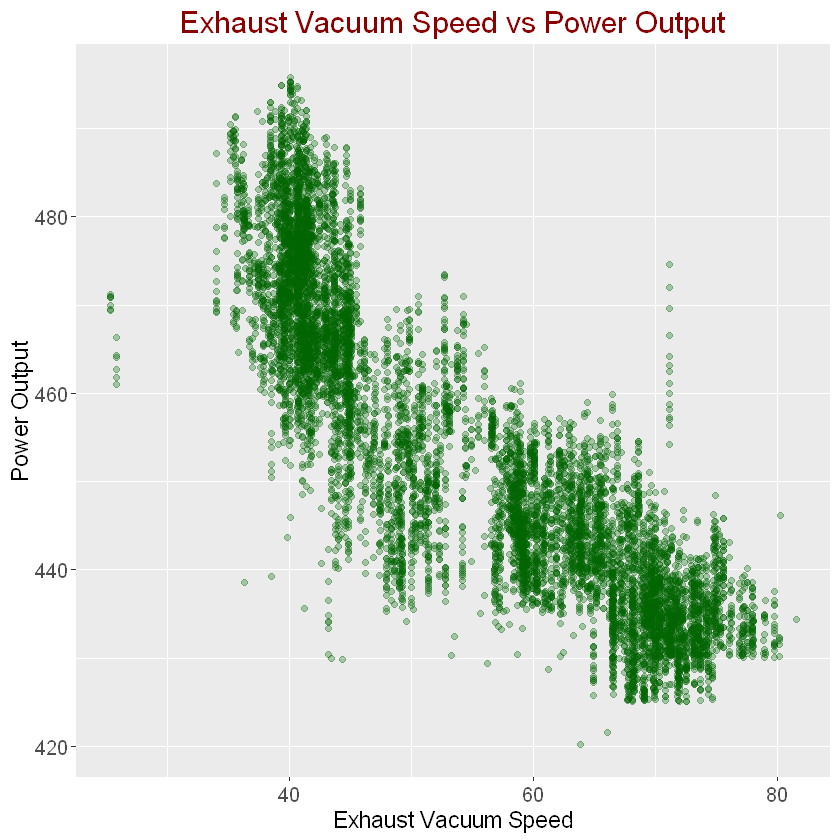

In [9]:
df %>% ggplot(aes(V, PE)) + geom_point(color = "darkgreen", alpha = 0.3) +
    ggtitle("Exhaust Vacuum Speed vs Power Output") + xlab("Exhaust Vacuum Speed") +
    ylab("Power Output") + theme(plot.title = element_text(color = "darkred", size = 18, hjust = 0.5),
                                 axis.text.y = element_text(size = 12),
                                 axis.text.x = element_text(size = 12, hjust = 0.5),
                                 axis.title.y = element_text(size = 14),
                                 axis.title.x = element_text(size = 14))

Correlation between Atmospheric Pressure and Power Output:

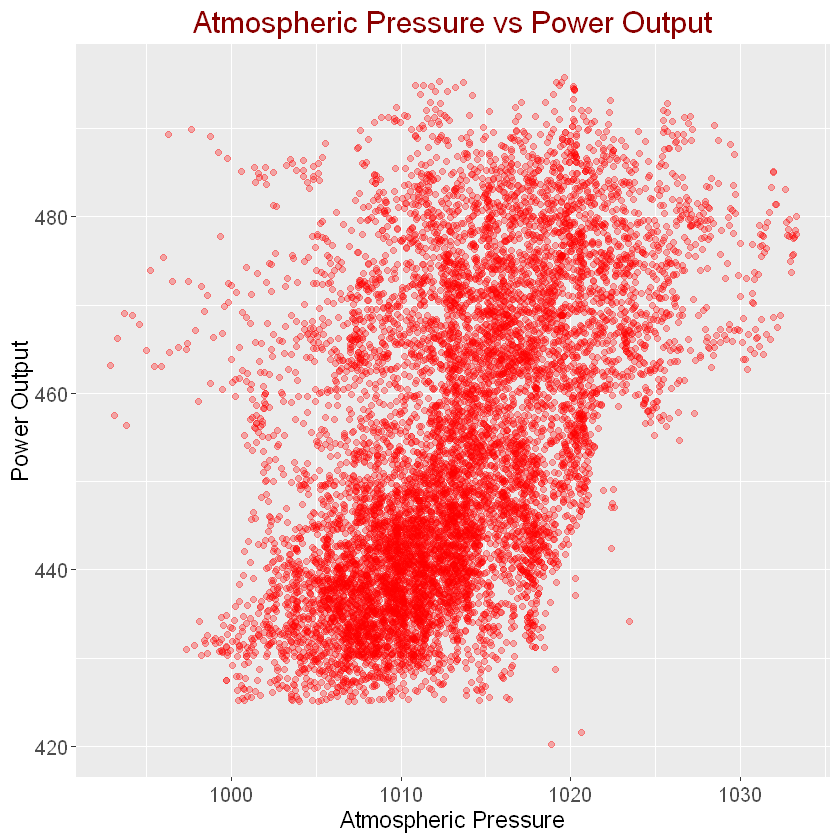

In [10]:
df %>% ggplot(aes(AP, PE)) + geom_point(color= "red", alpha = 0.3) +
    ggtitle("Atmospheric Pressure vs Power Output") + xlab("Atmospheric Pressure") +
    ylab("Power Output") + theme(plot.title = element_text(color = "darkred", size = 18, hjust = 0.5),
                      axis.text.y = element_text(size = 12),
                      axis.text.x = element_text(size = 12, hjust = 0.5),
                      axis.title.x = element_text(size = 14),
                      axis.title.y = element_text(size = 14))

Correlation between Relative Humidity and Power Output: 

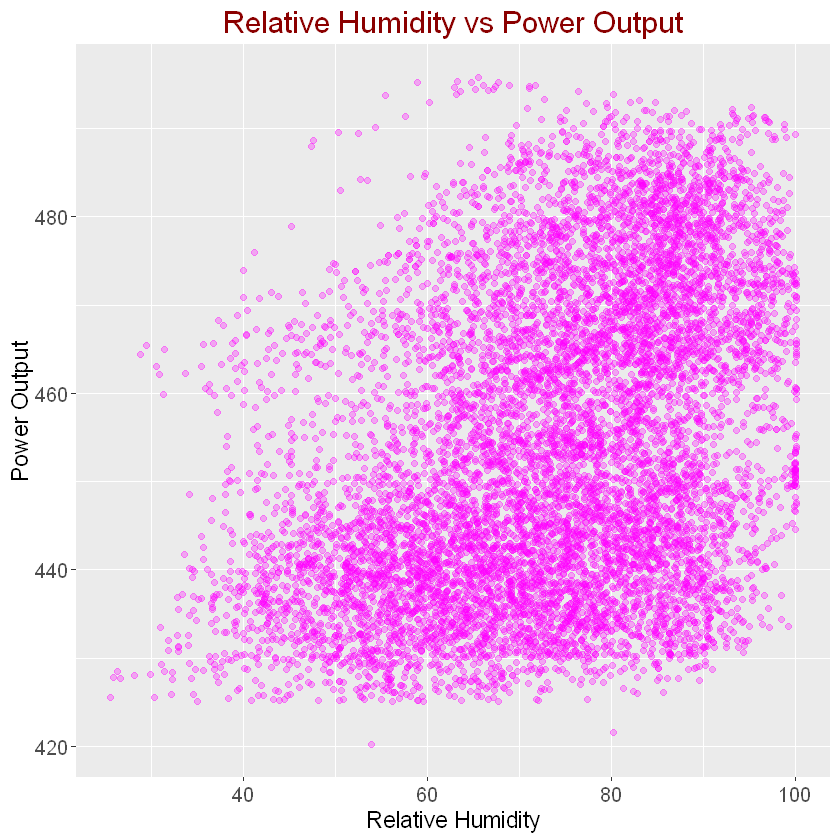

In [11]:
df %>% ggplot(aes(RH, PE)) + geom_point(color = "magenta", alpha = 0.3) +
    ggtitle("Relative Humidity vs Power Output") + xlab("Relative Humidity") +
    ylab("Power Output") + theme(plot.title = element_text(color = "darkred", size = 18, hjust = 0.5),
                      axis.text.y = element_text(size = 12),
                      axis.text.x = element_text(size = 12,hjust = 0.5),
                      axis.title.x = element_text(size = 14),
                      axis.title.y = element_text(size = 14))

Correlation Heatmap: 

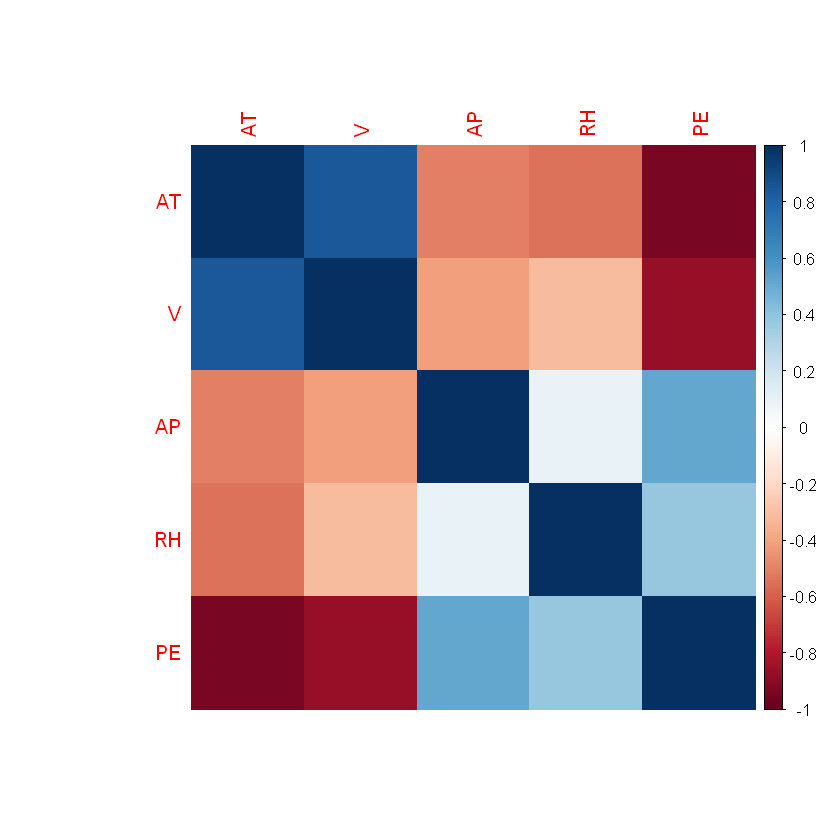

In [12]:
corr = cor(df)
corrplot(corr, method = "color")

As shown in the correlation heatmap above, the target is correlated with the features. However, we also observe correlation among the features, hence we have multi-collinearity problem.

I will use regularization to check if the collinearity we observe has a significant impact on the performance of linear regression model.

#### Data Modeling

All the columns are numeric and there are no missing values, which makes our modeling task strightforward.

Now, let's model the data to predict what the power output will be given a set of sensor readings. The first model will be based on simple linear regression since we saw some linear patterns in our data based on the scatter plots and correlation heatmap during the exploration stage.

In [13]:
library(caret)

Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift




Let's split the original dataset into training and test datasets:

In [14]:
set.seed(100)

# Create index for testing and training data
in_train <- createDataPartition(y = df$PE, p = 0.8, list = FALSE)

# Subset df data to training
training <- df[in_train,]

# Subset the rest of df to test
testing <- df[-in_train,]

message("the training set is about 80%  and the test set is about 20% of the data")

rbind("Training set" = nrow(training) / nrow(df), "Testing set" = nrow(testing) / nrow(df)) %>% round(2) * 100

the training set is about 80%  and the test set is about 20% of the data



Training set,80
Testing set,20


#### First Model with Linear Regression

In [15]:
LM <- train(training[,1:4], training[,5], method = "lm", preProc = c("center", "scale"))

message("Linear Regression: Model performance on the training set")

LM$results[c("RMSE", "Rsquared")] %>% round(2)

summary(LM)

Linear Regression: Model performance on the training set



RMSE,Rsquared
4.55,0.93



Call:
lm(formula = .outcome ~ ., data = dat)

Residuals:
    Min      1Q  Median      3Q     Max 
-43.327  -3.171  -0.088   3.223  17.389 

Coefficients:
             Estimate Std. Error  t value Pr(>|t|)    
(Intercept) 454.37369    0.05226 8694.845  < 2e-16 ***
AT          -14.73786    0.12786 -115.266  < 2e-16 ***
V            -2.97456    0.10385  -28.643  < 2e-16 ***
AP            0.36103    0.06289    5.741 9.79e-09 ***
RH           -2.27502    0.06831  -33.304  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.572 on 7651 degrees of freedom
Multiple R-squared:  0.9283,	Adjusted R-squared:  0.9282 
F-statistic: 2.475e+04 on 4 and 7651 DF,  p-value: < 2.2e-16


Let's Predict using the testing set:

 R_squared on the test data:



[1] 0.93

Root mean square error on the test data: 



[1] 4.5

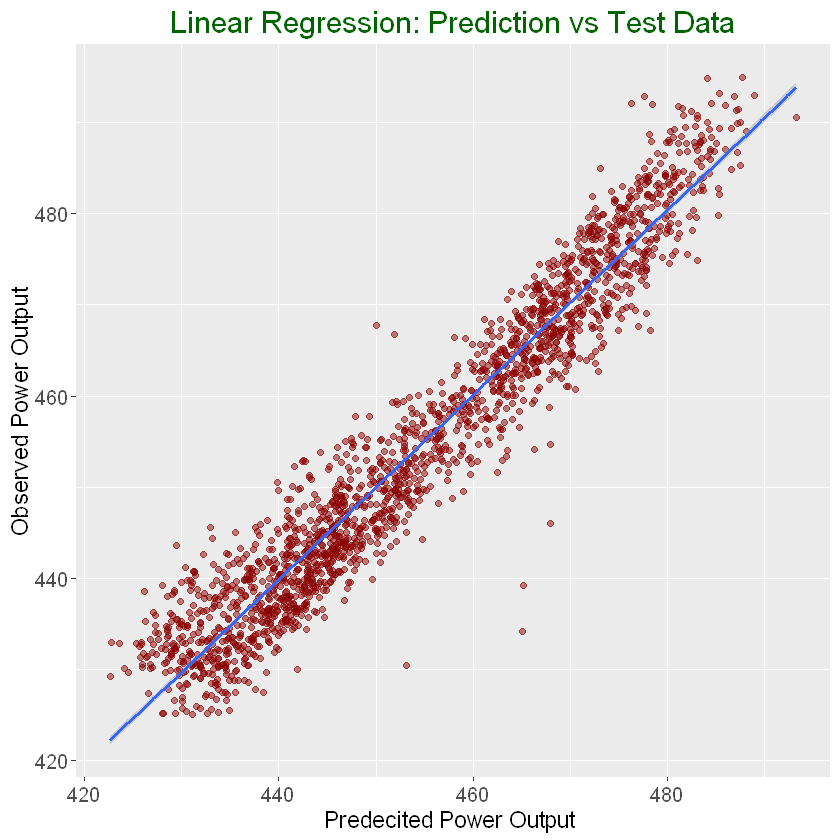

In [16]:
pred_LM <- predict(LM, testing[,1:4])

SSE = sum((testing[,5] - pred_LM) ^ 2)

SST = sum((testing[,5] - mean(training[,5])) ^ 2)

R_square = 1 - SSE / SST

message(" R_squared on the test data:") 
round(R_square, 2)

SSE = sum((testing[,5] - pred_LM)^2)

RMSE = sqrt(SSE/length(pred_LM))

message("Root mean square error on the test data: ")
round(RMSE, 2)

# Preparing data for ploting
data = as.data.frame(cbind(predicted = pred_LM, observed = testing$PE))

# Plot predictions vs test data
ggplot(data,aes(predicted, observed)) +geom_point(color = "darkred", alpha = 0.5) + 
      geom_smooth(method=lm)+ ggtitle('Linear Regression ') + ggtitle("Linear Regression: Prediction vs Test Data") +
      xlab("Predecited Power Output ") + ylab("Observed Power Output") +
      theme(plot.title = element_text(color = "darkgreen", size = 18, hjust = 0.5),
                     axis.text.y = element_text(size = 12),
                     axis.text.x = element_text(size = 12, hjust = 0.5),
                     axis.title.x = element_text(size = 14),
                     axis.title.y = element_text(size = 14)) 

#### Training a model with Extreme Gradient Boosting (XGBoost)

Convert the training and testing sets into DMatrixes: DMatrix is the recommended class in xgboost:

In [18]:
install.packages("xgboost")

package 'xgboost' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\luis_\AppData\Local\Temp\Rtmpi4bGfK\downloaded_packages


In [20]:
library(xgboost)

X_train = xgb.DMatrix(as.matrix(training %>% select(-PE)))

y_train = training$PE


X_test = xgb.DMatrix(as.matrix(testing %>% select(-PE)))
y_test = testing$PE

Warning message:
"package 'xgboost' was built under R version 3.6.3"

Attaching package: 'xgboost'


The following object is masked from 'package:dplyr':

    slice




Specify cross-validation method and number of folds. Also enable parallel computation:

In [24]:
xgb_trcontrol = trainControl(method = "cv", number = 5, allowParallel = TRUE, verboseIter = FALSE, returnData = FALSE)

Let's setting up the hyperparameters for  xgboost with the grid search:

In [22]:
xgbGrid <- expand.grid(nrounds = c(100,200), max_depth = c(10, 15, 20, 25), 
                       colsample_bytree = seq(0.5, 0.9, length.out = 5),
                       eta = 0.1, gamma = 0, min_child_weight = 1,
                       subsample = 1)  

Training the model:

In [25]:
set.seed(0) 

xgb_model = train(X_train, y_train,  trControl = xgb_trcontrol, tuneGrid = xgbGrid,
  method = "xgbTree")

[16:18:00] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:18:02] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:18:04] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:18:05] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:18:07] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:18:09] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:18:12] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[16:18:15] WARNING: amalgamation/../src/objective/regression_obj.cu:170: reg

Best values for hyperparameters:

In [27]:
xgb_model$bestTune

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
28,200,20,0.1,0,0.8,1,1


Model Evaluation:

In [29]:
predicted = predict(xgb_model, X_test)
residuals = y_test - predicted
RMSE = sqrt(mean(residuals ^ 2))

cat('The root mean square error of the test data is ', round(RMSE, 3),'\n')

The root mean square error of the test data is  3.097 


In [30]:
y_test_mean = mean(y_test)

# Calculate total sum of squares
tss =  sum((y_test - y_test_mean) ^ 2)

# Calculate residual sum of squares
rss =  sum(residuals ^ 2)

# Calculate R-squared
rsq  =  1 - (rss / tss)
cat('The R-square of the test data is ', round(rsq, 3), '\n') 

The R-square of the test data is  0.967 


Plotting actual vs predicted:

In [31]:
options(repr.plot.width=8, repr.plot.height=4)

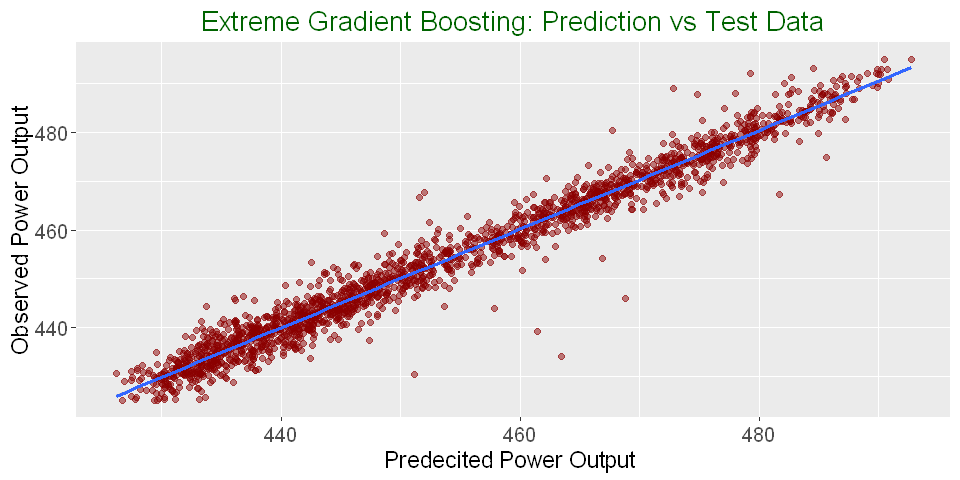

In [32]:
data = as.data.frame(cbind(predicted = predicted, observed = y_test))

# Plot predictions vs test data

ggplot(data,aes(predicted, observed)) + geom_point(color = "darkred", alpha = 0.5) + 
    geom_smooth(method=lm)+ ggtitle('Linear Regression ') + ggtitle("Extreme Gradient Boosting: Prediction vs Test Data") +
      xlab("Predecited Power Output ") + ylab("Observed Power Output") + 
        theme(plot.title = element_text(color="darkgreen",size=16,hjust = 0.5),
         axis.text.y = element_text(size=12), axis.text.x = element_text(size=12,hjust=.5),
         axis.title.x = element_text(size=14), axis.title.y = element_text(size=14))

We used Extreme Gradient Boosting to predict power output. We can see that it has better performance than linear model we tried in the first model. The RMSE with the test data decreased from more 4.5 to 3.1.